In [1]:
# more common imports
import pandas as pd
import numpy as np
from collections import Counter
import re
import os

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV

# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io
%matplotlib inline
sns.set()  # defines the style of the plots to be seaborn style

C:\Users\edufe\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Abre os dados

In [2]:
#Verifica os dados no diretorio

Data = os.listdir("../../Filter/Tweets_Filtered/")
for i in range(len(Data)):
    Data[i] = Data[i].split(".")[0]
    
Pessoas = ["realDonaldTrump", "jairbolsonaro", "hbredda", "gui_benchimol", "pedrocerize"]

NoticiasPolitica = ["OGloboPolitica", "folha_poder", "GloboNews", "EstadaoPolitica", 
                    "RevistaEpoca", "valoreconomico", "g1politica", "conexaopolitica", "EstadaoEconomia", 
                    "UOLEconomia", "folha_mercado", "g1economia", "OGlobo_Economia"]


Noticias = ["UOL", "folha", "g1", "VEJA", "cartacapital", "RevistaISTOE"]

#Monta um dicionario com todos datasets de twites de todas as pessoas
Alvo = NoticiasPolitica


AllData = pd.DataFrame()
for i in Alvo:
    if i in Data:
        MoreData = pd.read_csv("../../Filter/Tweets_Filtered/{0}".format(i+".csv"), sep=";", decimal=",", encoding='utf-16')
        AllData = pd.concat([AllData, MoreData])
    else:
        print("{0} não disponivel".format(i))
        
AllData = AllData.reset_index(drop=True)

In [3]:
label_encoder = LabelEncoder()

label_encoder.fit(AllData.Pessoa)
AllData['Pessoa_id'] = label_encoder.transform(AllData.Pessoa)

In [4]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id
24775,conexaopolitica,2018-12-28 22:55:40,filliperinauro agradecemos o seu apoio fillip...,1,5,1,7
8468,GloboNews,2019-03-06 11:24:50,o empresário estava preso desde novembro do an...,4,32,1,2
31904,folha_mercado,2019-04-29 05:19:03,governos devem ser responsáveis pela poupança ...,1,3,1,8
35616,g1economia,2019-04-16 12:06:25,cotação do dólar 16 04 2019,0,5,1,10
11597,EstadaoPolitica,2018-09-06 23:22:05,segundo suspeito pelo ataque contra jair bolso...,65,85,1,1


In [5]:
document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 13.991752676762806.
The minimum number of words in a document is: 2.
The maximum number of words in a document is: 30.


In [6]:
smallerthen4 = document_lengths <= 5

for i in range(len(document_lengths)):
    if smallerthen4[i]:
        AllData = AllData.drop(i)

document_lengths = np.array(list(map(len, AllData.Texto.str.split(' '))))

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\edufe\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['document_sentences'] = df.Texto.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(sentences),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(AllData)

In [9]:
def lda_get_good_tokens(df):
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.Texto))
    df['tokenized_text'] = list(df.tokenized_text)

lda_get_good_tokens(AllData)

In [10]:
print(nltk.corpus.stopwords.words('portuguese')[0:20])

['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as']


In [11]:
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('portuguese')[0:20]
    
    del(stopwords[stopwords.index("não")])
    ManualStop = ["istoégente", "expressoepoca", "globonews", "estudioi", "rt", "andreiasadi",
                  "’", "‘", "”", "“", "r", ",", ".", "…", "diz", "à", "ao"]
    Numbers = list(range(10))
    stopwords = stopwords + ManualStop + Numbers
    
    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(AllData)

In [12]:
dictionary = Dictionary(documents=AllData.stopwords_removed.values)

print("Found {} words.".format(len(dictionary.values())))

Found 29532 words.


In [13]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 12050 words.


In [14]:
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stopwords_removed))
    
document_to_bow(AllData)

In [15]:
def lda_preprocessing(df):
    """ All the preprocessing steps for LDA are combined in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    lda_get_good_tokens(df)
    remove_stopwords(df)
    document_to_bow(df)

In [16]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow
18190,valoreconomico,2019-03-04 19:50:32,at amp t reestrutura seus novos ativos em holl...,4,12,1,12,[at amp t reestrutura seus novos ativos em hol...,"[[at, amp, t, reestrutura, seus, novos, ativos...","[at, amp, t, reestrutura, seus, novos, ativos,...","[at, amp, t, reestrutura, seus, novos, ativos,...","[(681, 1), (814, 1), (865, 1), (1686, 1), (667..."
4768,folha_poder,2019-01-30 02:48:02,juíza rejeita pedido de lula para ir a enterro...,16,33,1,9,[juíza rejeita pedido de lula para ir a enterr...,"[[juíza, rejeita, pedido, de, lula, para, ir, ...","[juíza, rejeita, pedido, de, lula, para, ir, a...","[juíza, rejeita, pedido, lula, ir, enterro, ir...","[(22, 1), (408, 1), (476, 1), (974, 1), (987, ..."
18002,valoreconomico,2019-03-08 15:00:39,china teme que possível cúpula entre trump e x...,1,18,1,12,[china teme que possível cúpula entre trump e ...,"[[china, teme, que, possível, cúpula, entre, t...","[china, teme, que, possível, cúpula, entre, tr...","[china, teme, possível, cúpula, entre, trump, ...","[(63, 1), (117, 1), (385, 1), (1678, 1), (2255..."
27099,EstadaoEconomia,2018-02-27 00:30:00,apetite ao risco faz bolsa de são paulo renova...,4,12,1,0,[apetite ao risco faz bolsa de são paulo renov...,"[[apetite, ao, risco, faz, bolsa, de, são, pau...","[apetite, ao, risco, faz, bolsa, de, são, paul...","[apetite, risco, faz, bolsa, são, paulo, renov...","[(375, 1), (376, 1), (552, 1), (593, 1), (895,..."
17927,valoreconomico,2019-03-11 12:15:36,petrobras negocia por r 1 bilhão venda de camp...,4,17,1,12,[petrobras negocia por r 1 bilhão venda de cam...,"[[petrobras, negocia, por, r, 1, bilhão, venda...","[petrobras, negocia, por, r, 1, bilhão, venda,...","[petrobras, negocia, 1, bilhão, venda, campos,...","[(773, 1), (1134, 1), (1135, 1), (1215, 1), (2..."


# Análise de tópicos

In [17]:
corpus = AllData.bow

In [18]:
num_topics = 10
#A multicore approach to decrease training time
LDAmodel = LdaMulticore(corpus=corpus,
                        id2word=dictionary,
                        num_topics=num_topics,
                        workers=11,
                        chunksize=10000,
                        iterations = 5,
                        passes=7,
                        alpha='asymmetric')

In [19]:
def document_to_lda_features(lda_model, document):
    """ Transforms a bag of words document to features.
    It returns the proportion of how much each topic was
    present in the document.
    """
    topic_importances = LDAmodel.get_document_topics(document, minimum_probability=0)
    topic_importances = np.array(topic_importances)
    return topic_importances[:,1]

AllData['lda_features'] = list(map(lambda doc:
                              document_to_lda_features(LDAmodel, doc),
                              AllData.bow))

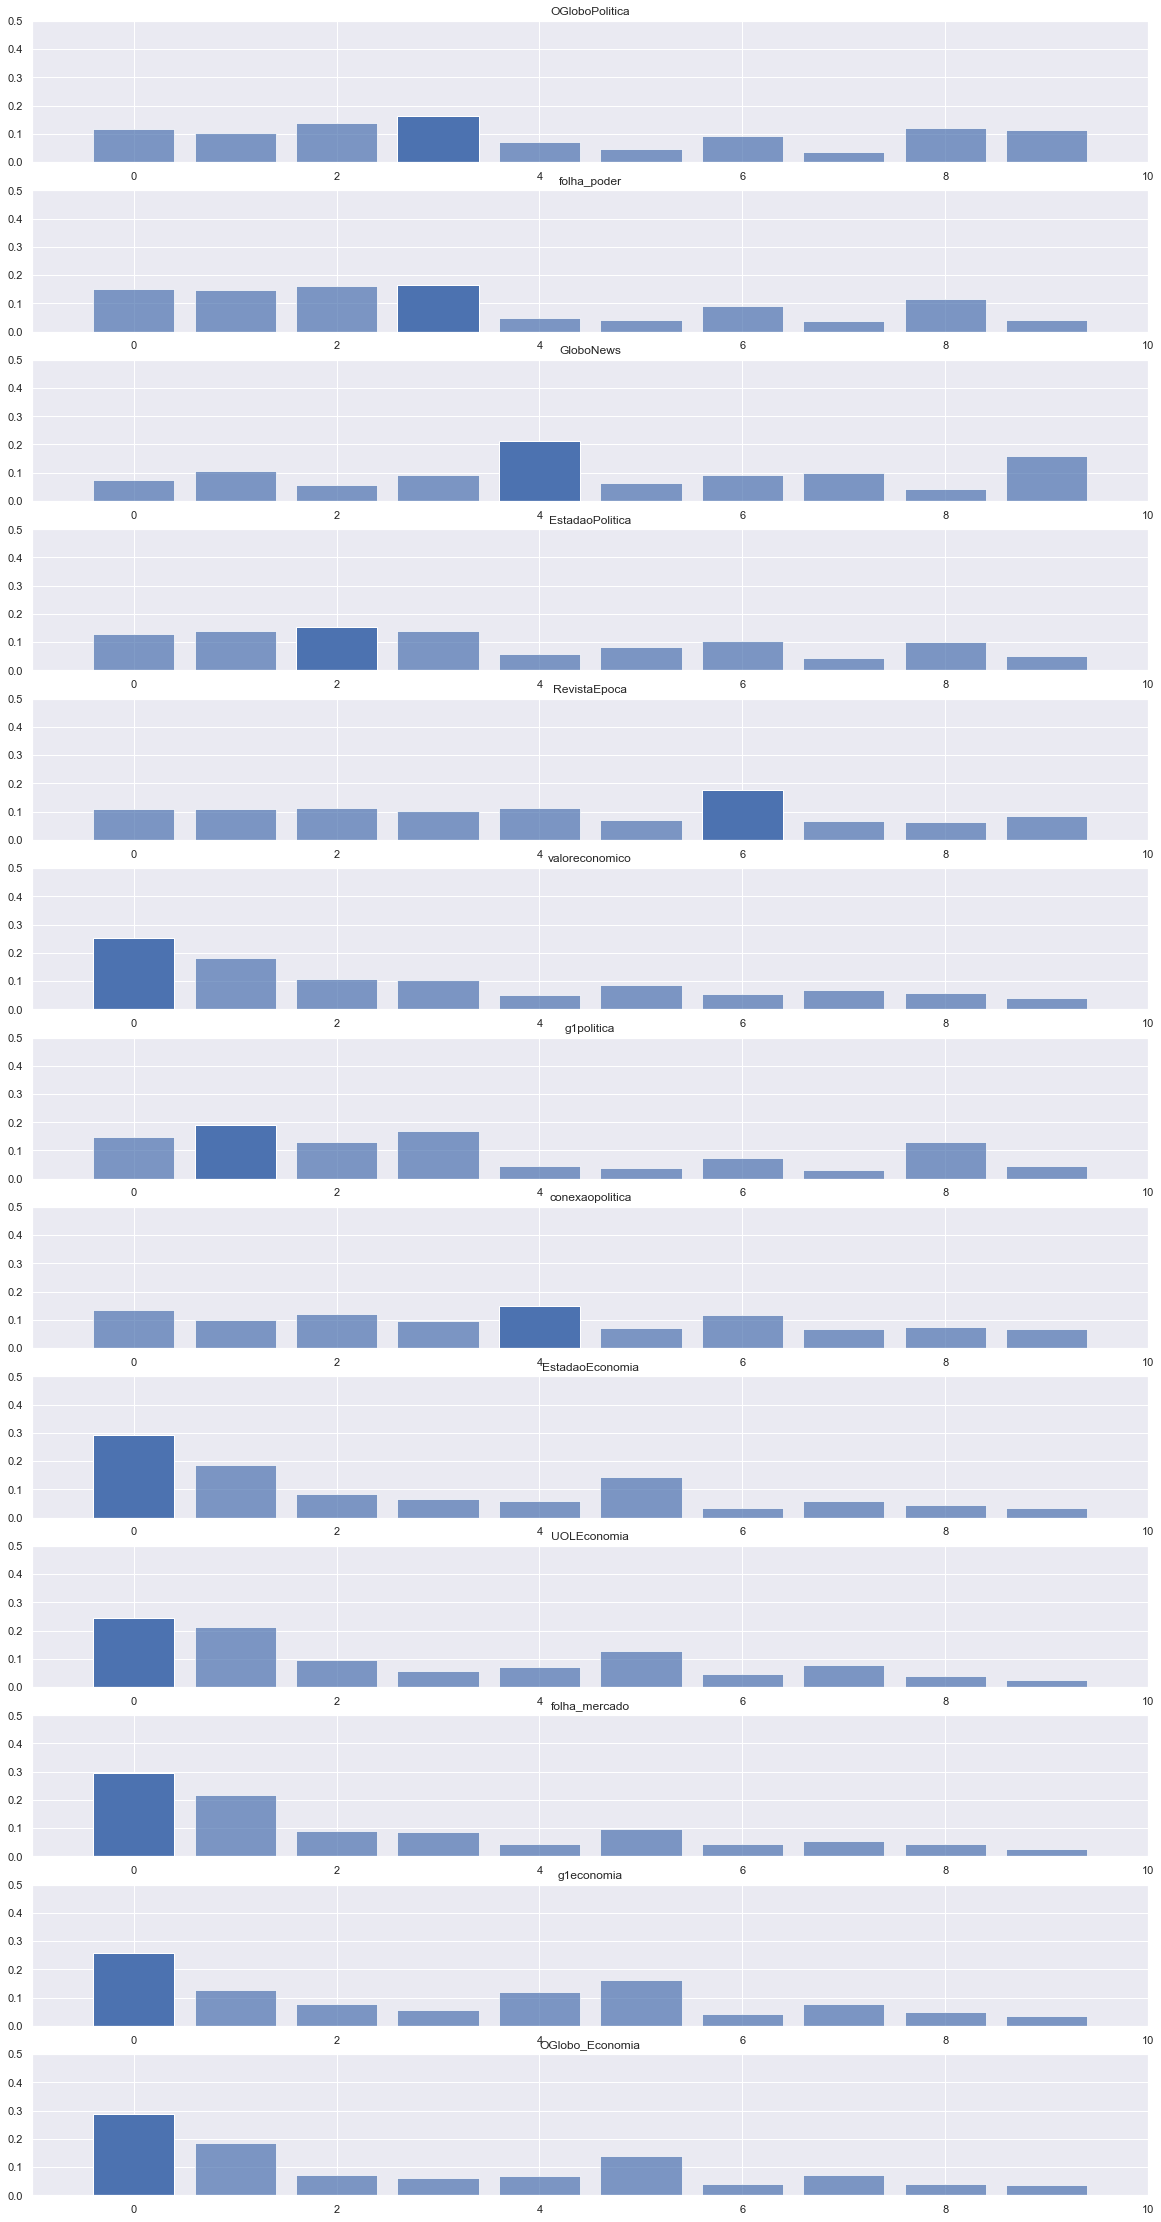

In [20]:
topic_distribution = []
for i in Alvo:
    topic_distribution.append(AllData.loc[AllData.Pessoa == i, 'lda_features'].mean())
    
ax = 0

Axes = [ax]*len(Alvo)
fig, Axes = plt.subplots(len(Alvo),figsize=(20,40))

nr_top_bars = 1

for i in range(len(Axes)):
    Axes[i].set_title(Alvo[i])

for ax, distribution in zip(Axes, topic_distribution):
    # Individual distribution barplots
    ax.bar(range(len(distribution)), distribution, alpha=0.7)
    rects = ax.patches
    for i in np.argsort(distribution)[-nr_top_bars:]:
        rects[i].set_alpha(1)
    # General plotting adjustments
    ax.set_xlim(-1, num_topics)
    ax.set_ylim(0,0.5)

In [21]:
AllData.sample(5)

,Pessoa,Data,Texto,Retweets,Likes,URL,Pessoa_id,document_sentences,tokenized_sentences,tokenized_text,stopwords_removed,bow,lda_features
13100,RevistaEpoca,2019-03-27 18:30:14,o presidente da câmara decidiu votar orçamento...,6,53,1,5,[o presidente da câmara decidiu votar orçament...,"[[o, presidente, da, câmara, decidiu, votar, o...","[o, presidente, da, câmara, decidiu, votar, or...","[presidente, câmara, decidiu, votar, orçamento...","[(106, 1), (198, 1), (285, 1), (906, 1), (908,...","[0.017207367345690727, 0.5927830934524536, 0.2..."
20762,g1politica,2019-02-04 16:00:13,vídeos sérgio moro apresenta propostas contra ...,3,25,1,11,[vídeos sérgio moro apresenta propostas contra...,"[[vídeos, sérgio, moro, apresenta, propostas, ...","[vídeos, sérgio, moro, apresenta, propostas, c...","[vídeos, sérgio, moro, apresenta, propostas, c...","[(12, 1), (262, 1), (404, 1), (652, 1), (1175,...","[0.017084985971450806, 0.012919302098453045, 0..."
35713,g1economia,2019-04-13 11:02:23,brecha obriga mudança em nova tecnologia de se...,2,5,1,10,[brecha obriga mudança em nova tecnologia de s...,"[[brecha, obriga, mudança, em, nova, tecnologi...","[brecha, obriga, mudança, em, nova, tecnologia...","[brecha, obriga, mudança, nova, tecnologia, se...","[(307, 1), (540, 1), (1067, 1), (1828, 1), (22...","[0.40777426958084106, 0.015579387545585632, 0...."
14725,RevistaEpoca,2018-11-08 17:46:51,rt expressoepoca confira a lista,16,0,1,5,[rt expressoepoca confira a lista ],"[[rt, expressoepoca, confira, a, lista]]","[rt, expressoepoca, confira, a, lista]","[confira, lista]","[(219, 1), (1083, 1)]","[0.09422807395458221, 0.051614582538604736, 0...."
10828,EstadaoPolitica,2018-11-27 23:00:00,bolsonaro diz que onyx vai liderar mas que tod...,5,15,1,1,[bolsonaro diz que onyx vai liderar mas que to...,"[[bolsonaro, diz, que, onyx, vai, liderar, mas...","[bolsonaro, diz, que, onyx, vai, liderar, mas,...","[bolsonaro, onyx, vai, liderar, mas, todo, mun...","[(19, 1), (61, 1), (67, 1), (202, 2), (816, 1)...","[0.20685599744319916, 0.01451519038528204, 0.2..."


In [22]:
def get_topic_top_words(lda_model, topic_id, nr_top_words=5):
    """ Returns the top words for topic_id from lda_model."""
    id_tuples = lda_model.get_topic_terms(topic_id, topn=nr_top_words)
    word_ids = np.array(id_tuples)[:,0]
    words = map(lambda id_: lda_model.id2word[id_], word_ids)
    return words

In [23]:
from pprint import pprint

print("Looking up top words from top topics")
for x in range(num_topics):
    top_words = get_topic_top_words(LDAmodel, x, nr_top_words=50)
    pprint(f"For topic {x+1}, the top words are:")
    pprint("{0}".format(", ".join(top_words)))
    pprint("")
print("")

Looking up top words from top topics
'For topic 1, the top words are:'
('bolsonaro, brasil, governo, vai, pode, ser, presidente, petrobras, mercado, '
 'sobre, eua, após, não, china, deve, é, estadão, vale, nova, dos, acordo, '
 'quer, anuncia, 2018, 2019, novo, são, bilhões, estados, venda, como, até, '
 'empresa, justiça, nos, boeing, país, tem, volta, lei, 3, mundo, contra, '
 'ministro, embraer, crescimento, empresas, entre, setor, us')
''
'For topic 2, the top words are:'
('previdência, reforma, governo, câmara, é, guedes, maia, bolsonaro, deve, '
 'senado, sobre, ccj, dos, após, presidente, está, projeto, como, deputados, '
 'entre, pode, será, proposta, aprova, vai, comissão, empresas, ministro, pec, '
 'não, mil, das, sem, aposentadoria, militares, quer, orçamento, mas, votação, '
 'apoio, paulo, economia, contra, mulheres, milhões, idade, energia, tem, '
 'temer, oposição')
''
'For topic 3, the top words are:'
('não, é, bolsonaro, governo, presidente, sobre, mourão, como, sena

In [24]:
TopicsData = np.array(list(AllData["lda_features"]))
TopicsData = np.transpose(TopicsData)

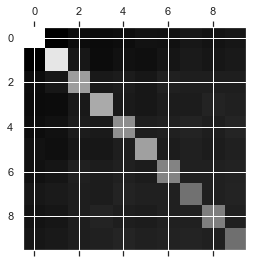

In [25]:
CovMatrix = np.cov(TopicsData)
plt.matshow(CovMatrix, cmap=plt.cm.gray)
plt.show()

## Filtra as ações

In [26]:
Stocks = ["ibov", "ITUB4", "PETR4", "Vale3", "BBDC4", "ABEV3", "BBAS3", "SANB3", "LREN3"]

Cols = {}
for i in range(len(Stocks)):
    Cols[Stocks[i]] = [i*4+i, i*4+i+1, i*4+i+2, i*4+i+3]

In [27]:
Var = 'ibov'
bolsa = pd.read_excel('../../Dados_Bolsa/Twt.xlsx', sheet_name="1h", usecols=Cols[Var],  skiprow=[0])

In [28]:
headers = list(bolsa.keys())
myheaders = [Var, "Price", "Volume", "Ticks"]

for i in range(len(headers)):
    bolsa.rename(columns={headers[i]: myheaders[i]}, inplace=True)
    
bolsa = bolsa.dropna()
bolsa.drop(bolsa.head(1).index,inplace=True)

bolsa = bolsa.reset_index(drop=True)

In [29]:
bolsa.head(5)

,ibov,Price,Volume,Ticks
0,2018-10-08 10:00:00,86283.7,0,119
1,2018-10-08 11:00:00,85686.7,0,120
2,2018-10-08 12:00:00,85408.6,0,120
3,2018-10-08 13:00:00,85267.7,0,120
4,2018-10-08 14:00:00,85686.7,0,120


In [30]:
ibov_len  = len(bolsa[Var])
ibov_len

1110

In [31]:
import datetime

ibov_data_precos = {}
DeadZoneUp = 0.3e-2
DeadZoneDown = 0.6e-2
# célula para identificar os preços de abertura e fechamento de cada dia
for i in range(0, ibov_len):
    data_completa = datetime.datetime.strptime(str(bolsa[Var][i]), '%Y-%m-%d %H:%M:%S')
    preco = bolsa['Price'][i]
    data = data_completa.strftime("%Y-%m-%d")
    if data not in ibov_data_precos:
        ibov_data_precos[data] = {}
        ibov_data_precos[data]['abertura'] = preco
        #caso só tenhamos informação de uma hora dentro de um dia, assumimos esse preco como o de fechamento tbm
        ibov_data_precos[data]['fechamento'] = preco 
        dia_anterior_completo =  data_completa - datetime.timedelta(days=1)
        dia_anterior_data = dia_anterior_completo.strftime("%Y-%m-%d")
        
        if(dia_anterior_data in ibov_data_precos):
            dia_anterior_fechamento = ibov_data_precos[dia_anterior_data]['fechamento']
            
            if(preco > dia_anterior_fechamento + dia_anterior_fechamento*DeadZoneUp):
                ibov_data_precos[data]['variacao'] = 2 #Subiu
            elif (preco < dia_anterior_fechamento - dia_anterior_fechamento*DeadZoneDown):
                ibov_data_precos[data]['variacao'] = 0 #Desceu
            else:
                ibov_data_precos[data]['variacao'] = 1
        else:
            #se não tivermos informações sobre o dia anterior, assumimos que a variacao foi neutra
            ibov_data_precos[data]['variacao'] = 0 
    else:
        if i < (ibov_len - 1):
            data_seguinte = datetime.datetime.strptime(str(bolsa[Var][i+1]), '%Y-%m-%d %H:%M:%S')
            if data_seguinte.date() > data_completa.date():
                ibov_data_precos[data]['fechamento'] = preco

Datesibov = list(ibov_data_precos.keys())
                
for i in range(4):
    print(Datesibov[i], ibov_data_precos[Datesibov[i]])

2018-10-08 {'abertura': 86283.67, 'fechamento': 86083.91, 'variacao': 0}
2018-10-09 {'abertura': 85864.42, 'fechamento': 86087.55, 'variacao': 1}
2018-10-10 {'abertura': 84590.04, 'fechamento': 83679.11, 'variacao': 0}
2018-10-11 {'abertura': 84492.8, 'fechamento': 82921.08, 'variacao': 2}


## Cria os Datasets

In [32]:
OutputData = []
InputData = []
for i in range(len(AllData)):
    data_completa = datetime.datetime.strptime(str(AllData["Data"].iloc[i]), '%Y-%m-%d %H:%M:%S')
    data = data_completa.strftime("%Y-%m-%d")
    if data in list(ibov_data_precos.keys()):
        OutputData.append(ibov_data_precos[data]["variacao"])
        Data = list(AllData['lda_features'].iloc[i])
        Data.append(AllData['Retweets'].iloc[i])
        Data.append(AllData['Likes'].iloc[i])
        Data.append(AllData['Pessoa_id'].iloc[i])
        InputData.append(Data)

In [33]:
len(OutputData), len(InputData), len(InputData[0])

(26261, 26261, 13)

In [34]:
print(InputData[1])

[0.01862182281911373, 0.014067755080759525, 0.011336336843669415, 0.009494305588304996, 0.008168094791471958, 0.007167330943048, 0.006385043263435364, 0.005756733473390341, 0.9141925573348999, 0.00481007806956768, 11, 24, 3]


In [35]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_classes, test_classes = train_test_split(InputData, OutputData, 
                                                                        test_size=0.2, stratify=OutputData)

## Distribuição das Classes:

In [36]:
trainlen = len(train_classes)
testlen = len(test_classes)

print("Treinamento:")
print(train_classes.count(0)/trainlen)
print(train_classes.count(1)/trainlen)
print(train_classes.count(2)/trainlen)
print()
print("Teste:")
print(test_classes.count(0)/testlen)
print(test_classes.count(1)/testlen)
print(test_classes.count(2)/testlen)

Treinamento:
0.32668507235338917
0.38071210967250574
0.2926028179741051

Teste:
0.32667047401484867
0.3807348181991243
0.29259470778602703


## Aplicação de Modelos

In [37]:
from sklearn.model_selection import cross_val_predict, cross_val_score

### Regressão Logistica

In [38]:
from sklearn.linear_model import LogisticRegression

Losgisticclf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

scores = cross_val_score(Losgisticclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.3793261  0.36623258 0.38071298]
0.3754238862181254


### Decision Tree

In [39]:
from sklearn import tree

tree = tree.DecisionTreeClassifier()

scores = cross_val_score(tree, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.33934894 0.3304775  0.34460695]
0.33814446214875127


### Randon Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

RandonForestclf = RandomForestClassifier(n_estimators=10, n_jobs=-1)

scores = cross_val_score(RandonForestclf, InputData, OutputData, cv=3, n_jobs=-1)

print(scores)
print(np.mean(scores))

[0.33398058 0.34932602 0.34792048]
0.3437423600779878


In [41]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 30, 100], 
    'min_impurity_decrease': [1e-5, 1e-6, 0]}
  ]

RandonForestclf = RandomForestClassifier(n_estimators=10, min_impurity_decrease=1e-3)

grid_search = GridSearchCV(RandonForestclf, param_grid, cv=5, scoring='accuracy', return_train_score=True, n_jobs=-1)

grid_search.fit(InputData, OutputData)

print(grid_search.best_params_, grid_search.best_score_)

BestParams = grid_search.best_params_

RandonForestclf = RandomForestClassifier(n_estimators=BestParams["n_estimators"], 
                                         min_impurity_decrease=BestParams["min_impurity_decrease"])

{'min_impurity_decrease': 1e-05, 'n_estimators': 100} 0.345836030615742


## Best Model

In [42]:
TopClassifier = RandonForestclf

y_pred = cross_val_predict(TopClassifier, InputData, OutputData, cv=3)

In [43]:
Output_Pred = list(y_pred)

print("Resultado Modelo:")
print(Output_Pred.count(0)/len(Output_Pred))
print(Output_Pred.count(1)/len(Output_Pred))
print(Output_Pred.count(2)/len(Output_Pred))

Resultado Modelo:
0.35912569970678954
0.41266516888161153
0.22820913141159896


In [44]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(OutputData, Output_Pred)
conf_mx

array([[3147, 3461, 1971],
       [3589, 4211, 2198],
       [2695, 3165, 1824]], dtype=int64)

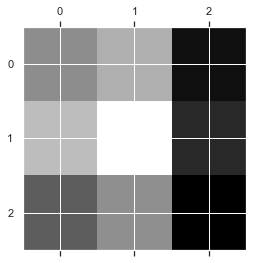

In [45]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [46]:
InputDataa = np.array(InputData)
OutputDataa = np.array(OutputData)
Output_Preda = np.array(Output_Pred)

In [47]:
AllResults = pd.DataFrame(InputData)
AllResults["Output"]= OutputDataa
AllResults["Output_pred"]= Output_Preda

AllResults.sample(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,Output,Output_pred
24840,0.040872,0.030977,0.192087,0.020887,0.650585,0.015768,0.014047,0.012665,0.011530,0.010582,2,5,10,1,2
24093,0.117900,0.049209,0.030079,0.010444,0.008985,0.758965,0.007029,0.006332,0.005765,0.005291,1,7,10,1,2
12994,0.614041,0.294096,0.020680,0.013057,0.011232,0.015899,0.009260,0.007916,0.007206,0.006614,4,27,12,0,1
7927,0.135100,0.085932,0.442578,0.013056,0.011232,0.009855,0.008779,0.007916,0.007206,0.278345,3,10,1,1,1
4158,0.394647,0.037387,0.013866,0.508232,0.009984,0.008760,0.007804,0.007036,0.006406,0.005879,10,16,9,1,1


In [48]:
ResultCorr = np.array(AllResults.corr())
AllResults.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,Output,Output_pred
0,1.000000,-0.191842,-0.154462,-0.170133,-0.166208,-0.110639,-0.145721,-0.118680,-0.148869,-0.136630,-0.038743,-0.034591,0.130513,-0.011380,-0.045331
1,-0.191842,1.000000,-0.100841,-0.188270,-0.158753,-0.151458,-0.140862,-0.105740,-0.139230,-0.123126,-0.046101,-0.042082,0.074579,0.029630,0.144323
2,-0.154462,-0.100841,1.000000,-0.130949,-0.097455,-0.129034,-0.069440,-0.101857,-0.105018,-0.095338,0.005804,0.016804,0.014228,0.001247,-0.016705
3,-0.170133,-0.188270,-0.130949,1.000000,-0.121782,-0.122907,-0.108339,-0.114479,-0.042452,-0.065564,0.011287,0.006637,0.005196,0.004859,-0.014757
4,-0.166208,-0.158753,-0.097455,-0.121782,1.000000,-0.075901,-0.069405,-0.040293,-0.098041,-0.036624,0.026238,0.032056,-0.128539,-0.025887,-0.051439
5,-0.110639,-0.151458,-0.129034,-0.122907,-0.075901,1.000000,-0.097954,-0.054394,-0.094841,-0.076271,-0.024260,-0.033789,0.033632,-0.001703,0.022649
6,-0.145721,-0.140862,-0.069440,-0.108339,-0.069405,-0.097954,1.000000,-0.075153,-0.081133,-0.059696,0.054513,0.047641,-0.084565,-0.009280,-0.080413
7,-0.118680,-0.105740,-0.101857,-0.114479,-0.040293,-0.054394,-0.075153,1.000000,-0.071351,-0.060952,0.004548,0.003545,-0.018549,-0.020816,-0.010395
8,-0.148869,-0.139230,-0.105018,-0.042452,-0.098041,-0.094841,-0.081133,-0.071351,1.000000,-0.072843,0.024487,0.024064,0.016693,0.041460,0.068396
9,-0.136630,-0.123126,-0.095338,-0.065564,-0.036624,-0.076271,-0.059696,-0.060952,-0.072843,1.000000,0.020374,0.013247,-0.158069,-0.020757,-0.060117


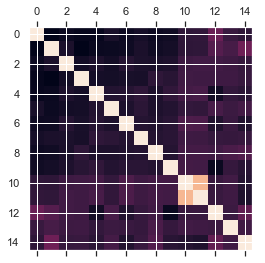

In [49]:
plt.matshow(ResultCorr)
plt.show()

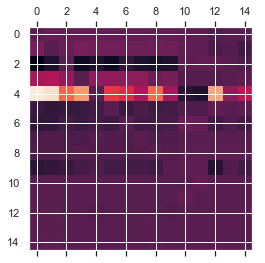

In [50]:
row_sums = ResultCorr.sum(axis=1, keepdims=True)
norm_corr = ResultCorr / row_sums
np.fill_diagonal(norm_corr, 0.005)

plt.matshow(norm_corr)
plt.show()